In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud

In [2]:
processed_df = pd.read_pickle("data/processed_recipes.pkl")
processed_df

,name,ingredients,description,instructions,cuisine,course,diet,prep_time,categorized_prep_time,cleaned_ingredients,allergens,processed_name,processed_instructions,processed_description,allergen_type,processed_ingredients,combined_all_contexts,combined_name_ingredients
0,Doddapatre Tambuli Recipe (Karpooravalli Thayi...,"4 cups Indian borage (Doddapatre) , cleaned an...",Doddapatre Tambuli Recipe is a popular healing...,"To begin making the Doddapatre Tambuli, first ...",Indian,Side Dish,Vegetarian,30.0,~30 min,"[indian borage doddapatre, curd dahi yogurt, c...",[yogurt],doddapatre tambuli karpooravalli thayir pachadi,doddapatre tambuli doddapatre leave dry towel ...,doddapatre tambuli popular healing cold yoghur...,[Dairy],indian borage doddapatre curd dahi yogurt cumi...,doddapatre tambuli karpooravalli thayir pachad...,doddapatre tambuli karpooravalli thayir pachad...
1,Fish Tandoori Recipe,"1 Fish , nicely washed with bones on (I used P...",Have you ever tried out fish tandoori? Trust m...,"To begin making the Fish Tandoori recipe, keep...",North Indian,Appetizer,High Protein Non Vegetarian,80.0,~1 hour 30 min,"[fish, curd dahi yogurt, onion, green chilli, ...",[fish],fish tandoori,fish tandoori head fin inside fish many horizo...,fish tandoori delicious chicken tandoori tando...,[Fish and Shellfish],fish curd dahi yogurt onion green chilli tando...,fish tandoori fish curd dahi yogurt onion gree...,fish tandoori fish curd dahi yogurt onion gree...
2,Arbi Shimla Mirch Sabzi Recipe – Colocasia Cap...,300 grams Colocasia root (Arbi) 1 Green Bell ...,Arbi Shimla Mirch Sabzi Recipe is a variation ...,To begin making the Arbi Shimla Mirch Sabzi Re...,North Indian,Main Course,No Onion No Garlic (Sattvic),55.0,~1 hour,"[colocasia root arbi, green bell pepper capsic...",[peanut],arbi shimla mirch sabzi colocasia capsicum sabzi,arbi shimla mirch sabzi arbi pressure pressure...,arbi shimla mirch sabzi variation aloo capsicu...,"[Tree Nuts and Peanuts, Legumes and Seeds]",colocasia root arbi green bell pepper capsicum...,arbi shimla mirch sabzi colocasia capsicum sab...,arbi shimla mirch sabzi colocasia capsicum sab...
3,Ambur Style Brinjal Curry Recipe,5 Brinjal (Baingan / Eggplant) 1 Onion 2 Tom...,Brinjal Curry is prepared in different ways in...,To begin making the Ambur Style Brinjal Curry ...,Indian,Lunch,Vegetarian,20.0,~30 min,"[brinjal baingan eggplant, onion, ginger garli...","[sesame, peanut, mustard]",ambur style brinjal curry,ambur style brinjal curry oil heavy bottomed o...,brinjal curry different way different region s...,"[Legumes and Seeds, Tree Nuts and Peanuts]",brinjal baingan eggplant onion ginger garlic p...,ambur style brinjal curry brinjal baingan eggp...,ambur style brinjal curry brinjal baingan eggp...
4,Mavinakayi Menasinakai Curry Recipe - Raw Man...,"1 cup Mango (Raw) , diced 2 tablespoons Jagge...",Mangalorean Mavinakayi Menasinakai Curry Recip...,To begin making Mangalorean Mavinakayi Menasin...,Mangalorean,Side Dish,Vegetarian,35.0,~45 min,"[mango raw, jaggery, turmeric powder haldi, ta...",[sesame],mavinakayi menasinakai curry raw mango coconut...,mangalorean mavinakayi menasinakai curry raw m...,mangalorean mavinakayi menasinakai curry raw m...,[Legumes and Seeds],mango raw jaggery turmeric powder haldi tamari...,mavinakayi menasinakai curry raw mango coconut...,mavinakayi menasinakai curry raw mango coconut...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9491,Spinach Oats Vada Recipe,"Spinach Leaves (Palak), Chana dal (Bengal Gram...",Spinach Oats Vada Recipe is a healthy twist to...,"To prepare Spinach Oats Vada Recipe, in a larg...",South Indian,Snack,Vegetarian,50.0,~1 hour,"[spinach leave palak, chana dal bengal gram da...",[oats],spinach oats vada,spinach oats vada large mixing ingredient vada...,spinach oats vada healthy twist vada superfood...,[Grains and Gluten],spinach leave palak chana dal bengal gram dal ...,spinach oats vada spinach leave palak chana da...,sp

Train SVD model on TF-IDF and Count vectorizers and find the best number of topics using coherence scores

In [3]:
def compute_coherence_scores_svd(texts, vectorizer, num_topics_range):
    coherence_scores = []
    
    # Transform texts to TF-IDF matrix
    tfidf_matrix = vectorizer.fit_transform(texts)
    
    # Tokenize each text in `texts` for Gensim's coherence calculation
    tokenized_texts = [text.split() for text in texts]
    dictionary = Dictionary(tokenized_texts)
    corpus = [dictionary.doc2bow(text) for text in tokenized_texts]
    
    # Iterate over each specified topic count
    for num_topics in num_topics_range:
        svd_model = TruncatedSVD(n_components=num_topics, random_state=42)
        svd_matrix = svd_model.fit_transform(tfidf_matrix)
        
        # Extract top words for each topic and format as list of tokens
        feature_names = vectorizer.get_feature_names_out()
        topics = [[feature_names[i] for i in topic.argsort()[:-11:-1]] for topic in svd_model.components_]
        
        tokenized_topics = [[word for word in topic] for topic in topics]# Coherence model requires a list of tokenized topics

        coherence_model = CoherenceModel(
            topics=tokenized_topics, 
            texts=tokenized_texts, 
            dictionary=dictionary, 
            coherence='c_v'
        )
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append(coherence_score)
        
        print(f"Number of Topics: {num_topics}, Coherence Score: {coherence_score}")

    # Plot coherence scores
    plt.figure(figsize=(10, 6))
    plt.plot(num_topics_range, coherence_scores, marker='o', linestyle='-', color='b')
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.title("Coherence Scores by Number of Topics")
    plt.show()
    
    # Find the best number of topics
    best_num_topics = num_topics_range[coherence_scores.index(max(coherence_scores))]
    print(f"Best Number of Topics: {best_num_topics} with Coherence Score: {max(coherence_scores)}")

    return coherence_scores, best_num_topics

Compare the performance of the SVD model on TF-IDF using "processed_name", "combined_name_ingredients", and "comnined_all_contexts" columns separately

Number of Topics: 10, Coherence Score: 0.28978207893739194
Number of Topics: 11, Coherence Score: 0.2870600896375178
Number of Topics: 12, Coherence Score: 0.2905978074085674
Number of Topics: 13, Coherence Score: 0.29230767833949955
Number of Topics: 14, Coherence Score: 0.27468710447253114
Number of Topics: 15, Coherence Score: 0.29649402709391415
Number of Topics: 16, Coherence Score: 0.2831170641180883
Number of Topics: 17, Coherence Score: 0.2898984094719865
Number of Topics: 18, Coherence Score: 0.27873681422968327
Number of Topics: 19, Coherence Score: 0.2859551032442448
Number of Topics: 20, Coherence Score: 0.28163981667833893


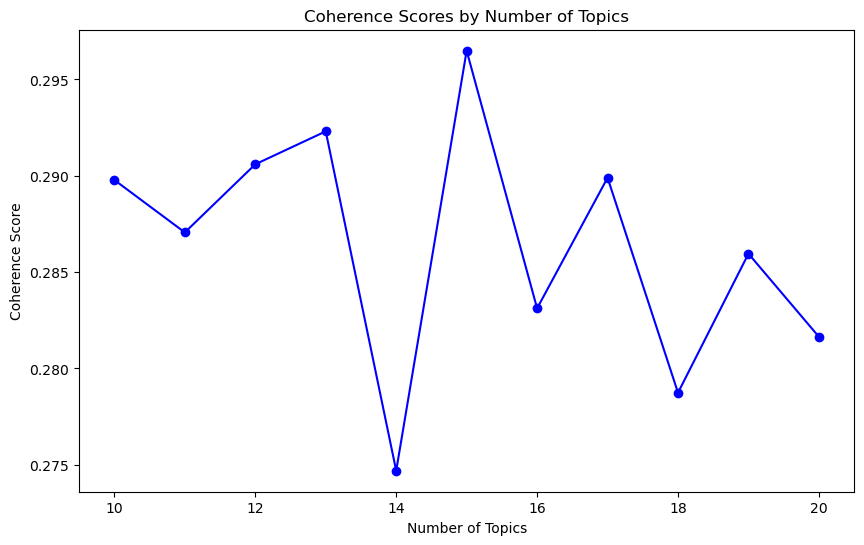

Best Number of Topics: 15 with Coherence Score: 0.29649402709391415


In [4]:
name_coherence_scores_svd_tfidf = compute_coherence_scores_svd(processed_df['processed_name'], TfidfVectorizer(), range(10, 21, 1))

Number of Topics: 1, Coherence Score: 0.6915303353460391
Number of Topics: 2, Coherence Score: 0.7952842223615988
Number of Topics: 3, Coherence Score: 0.7451983748032885
Number of Topics: 4, Coherence Score: 0.7150048845941033
Number of Topics: 5, Coherence Score: 0.6790001762688092
Number of Topics: 6, Coherence Score: 0.6651610281005308
Number of Topics: 7, Coherence Score: 0.6606078216700327
Number of Topics: 8, Coherence Score: 0.6490054716005318


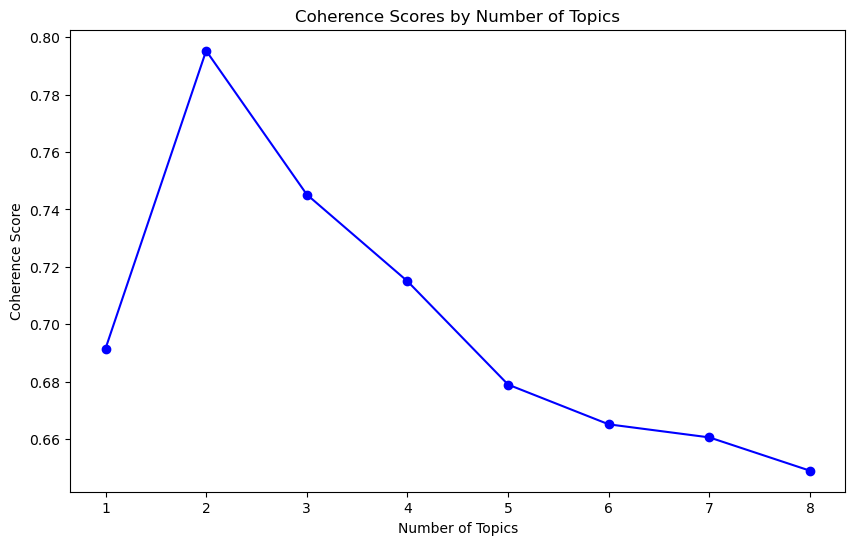

Best Number of Topics: 2 with Coherence Score: 0.7952842223615988


In [5]:
name_ingredients_coherence_scores_svd_tfidf = compute_coherence_scores_svd(processed_df['combined_name_ingredients'], TfidfVectorizer(), range(1, 9, 1))

Number of Topics: 1, Coherence Score: 0.5949663579641742
Number of Topics: 2, Coherence Score: 0.567011161709826
Number of Topics: 3, Coherence Score: 0.5791617507452015
Number of Topics: 4, Coherence Score: 0.5229352888824517
Number of Topics: 5, Coherence Score: 0.48784591255770254
Number of Topics: 6, Coherence Score: 0.5008718884245323
Number of Topics: 7, Coherence Score: 0.4983227321838449
Number of Topics: 8, Coherence Score: 0.4782545864215928


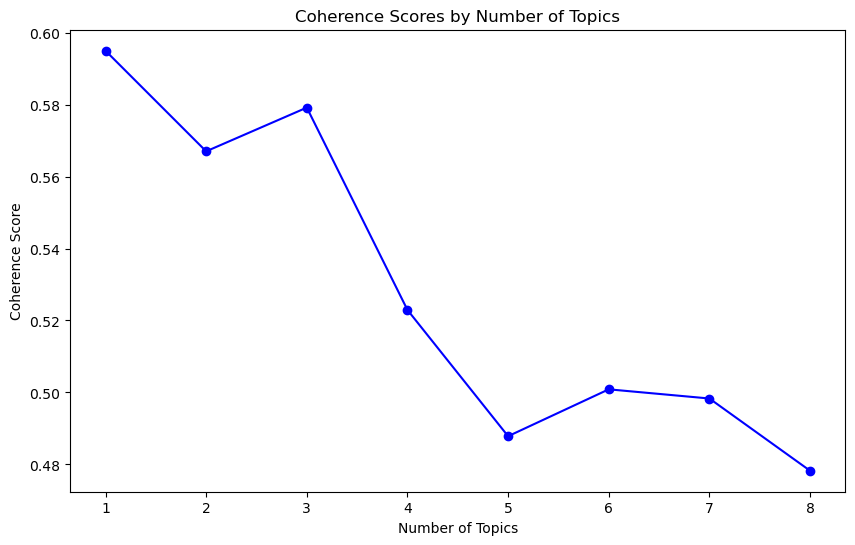

Best Number of Topics: 1 with Coherence Score: 0.5949663579641742


In [6]:
all_coherence_scores_svd_tfidf = compute_coherence_scores_svd(processed_df['combined_all_contexts'], TfidfVectorizer(), range(1, 9, 1))

Compare the performanc of the SVD on Count vectorizer "processed_name", "combined_name_ingredients", and "comnined_all_contexts" columns separately

Number of Topics: 1, Coherence Score: 0.32747617842211824
Number of Topics: 2, Coherence Score: 0.30166519834894745
Number of Topics: 3, Coherence Score: 0.36330030808995356
Number of Topics: 4, Coherence Score: 0.3480034982070445
Number of Topics: 5, Coherence Score: 0.3368158243804163
Number of Topics: 6, Coherence Score: 0.3183631931708423
Number of Topics: 7, Coherence Score: 0.3279089212236196
Number of Topics: 8, Coherence Score: 0.32264298398599245
Number of Topics: 9, Coherence Score: 0.3285419356338879
Number of Topics: 10, Coherence Score: 0.2974709760336278


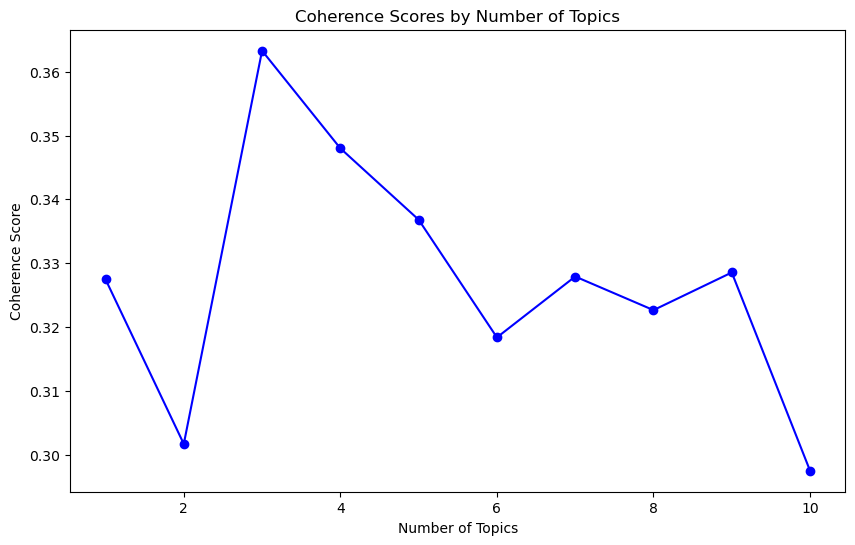

Best Number of Topics: 3 with Coherence Score: 0.36330030808995356


In [7]:
name_coherence_scores_svd_countvect = compute_coherence_scores_svd(processed_df['processed_name'], CountVectorizer(), range(1, 11, 1))

Number of Topics: 1, Coherence Score: 0.7210354061989326
Number of Topics: 2, Coherence Score: 0.6748673311502363
Number of Topics: 3, Coherence Score: 0.7123033787974385
Number of Topics: 4, Coherence Score: 0.7358553478194537
Number of Topics: 5, Coherence Score: 0.6886583549060439
Number of Topics: 6, Coherence Score: 0.6812085070572755
Number of Topics: 7, Coherence Score: 0.6528381208645812
Number of Topics: 8, Coherence Score: 0.6372326580328647
Number of Topics: 9, Coherence Score: 0.6409766915934827
Number of Topics: 10, Coherence Score: 0.6283006489078702


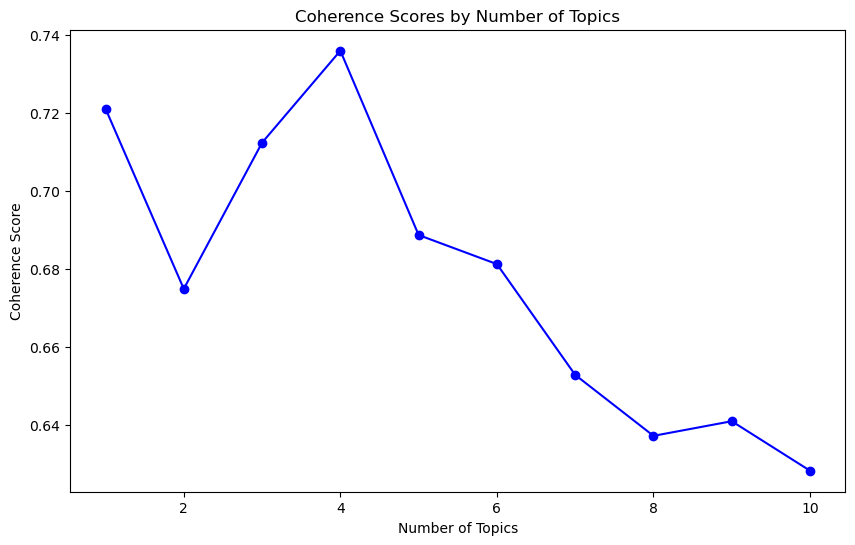

Best Number of Topics: 4 with Coherence Score: 0.7358553478194537


In [8]:
name_ingredients_coherence_scores_svd_countvect = compute_coherence_scores_svd(processed_df['combined_name_ingredients'], CountVectorizer(), range(1, 11, 1))

Number of Topics: 1, Coherence Score: 0.598958548467784
Number of Topics: 2, Coherence Score: 0.6883841676710138
Number of Topics: 3, Coherence Score: 0.6855059446083555
Number of Topics: 4, Coherence Score: 0.6238290224917639
Number of Topics: 5, Coherence Score: 0.5970810716174093
Number of Topics: 6, Coherence Score: 0.6000260576414845
Number of Topics: 7, Coherence Score: 0.5717753765720713
Number of Topics: 8, Coherence Score: 0.5308355111319782
Number of Topics: 9, Coherence Score: 0.5278237025959013
Number of Topics: 10, Coherence Score: 0.5156432409007089


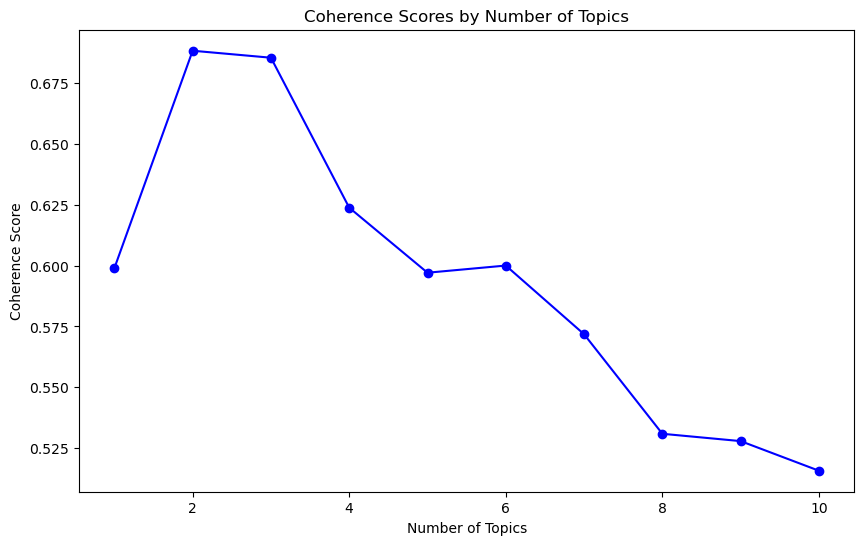

Best Number of Topics: 2 with Coherence Score: 0.6883841676710138


In [9]:
all_coherence_scores_svd_countvect = compute_coherence_scores_svd(processed_df['combined_all_contexts'], CountVectorizer(), range(1, 11, 1))

Choose the model with the highest coherence score for more explorations

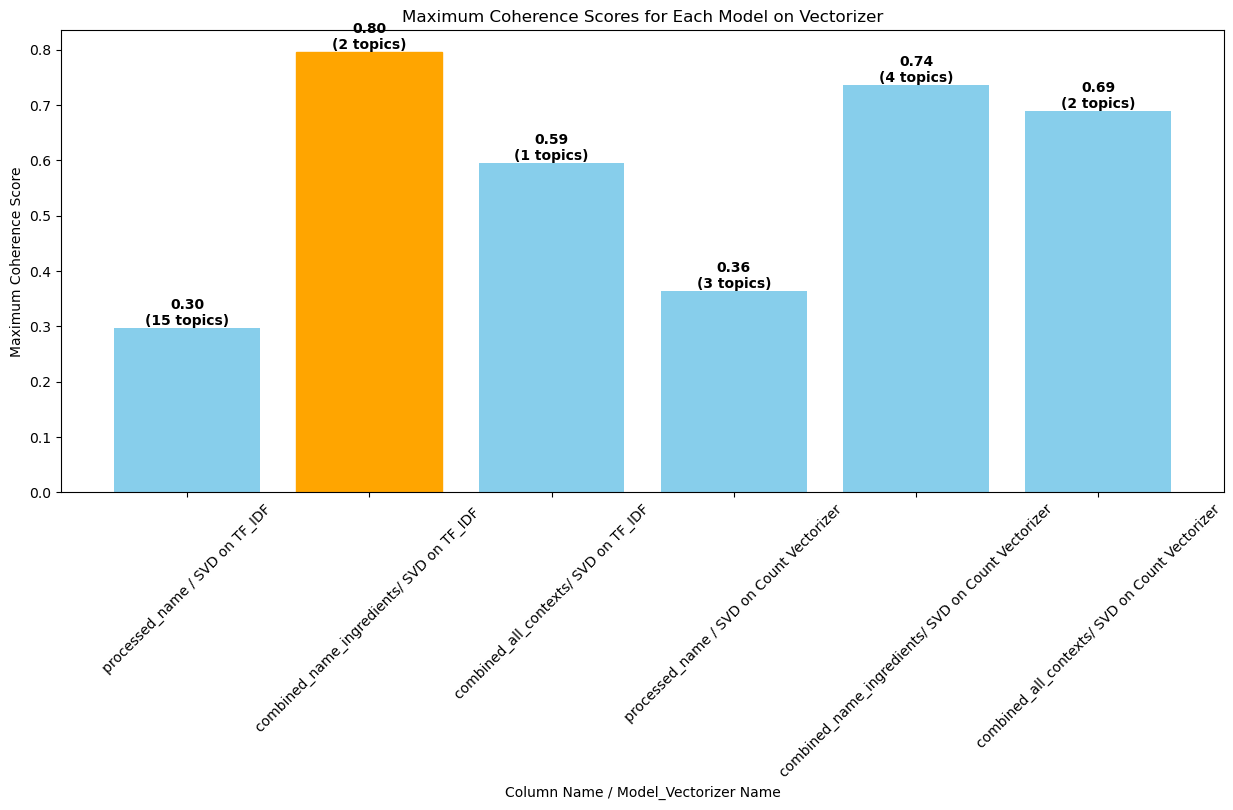

In [10]:
coherence_scores_dict = {"processed_name / SVD on TF_IDF": name_coherence_scores_svd_tfidf[0],
    "combined_name_ingredients/ SVD on TF_IDF ": name_ingredients_coherence_scores_svd_tfidf[0],
    "combined_all_contexts/ SVD on TF_IDF": all_coherence_scores_svd_tfidf[0], 
    "processed_name / SVD on Count Vectorizer": name_coherence_scores_svd_countvect[0],
    "combined_name_ingredients/ SVD on Count Vectorizer": name_ingredients_coherence_scores_svd_countvect[0],
    "combined_all_contexts/ SVD on Count Vectorizer": all_coherence_scores_svd_countvect[0]}

# Best topic numbers
best_num_topics = [name_coherence_scores_svd_tfidf[1], name_ingredients_coherence_scores_svd_tfidf[1], all_coherence_scores_svd_tfidf[1],
    name_coherence_scores_svd_countvect[1], name_ingredients_coherence_scores_svd_countvect[1], all_coherence_scores_svd_countvect[1]]

# Extract coherence scores and assign best topics
labels = list(coherence_scores_dict.keys())
max_scores = [max(scores) for scores in coherence_scores_dict.values()]
best_topics_for_each = [best_num_topics[i] for i in range(len(labels))]

plt.figure(figsize=(15, 6))
bars = plt.bar(labels, max_scores, color='skyblue')

# Highlight the bar with the highest coherence score
max_index = max_scores.index(max(max_scores))
bars[max_index].set_color('orange')

# Annotate each bar with the coherence score and best topic count
for bar, score, topics in zip(bars, max_scores, best_topics_for_each):
    plt.text(bar.get_x() + bar.get_width() / 2, score, f'{score:.2f}\n({topics} topics)', 
             ha='center', va='bottom', fontweight='bold', color='black')

plt.xlabel("Column Name / Model_Vectorizer Name")
plt.ylabel("Maximum Coherence Score")
plt.title("Maximum Coherence Scores for Each Model on Vectorizer")
plt.xticks(rotation=45)

plt.show()